In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [77]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pmdarima as pm


### Fit a seasonal ARIMA model of your choice to the daily covid19 cases of the country in covid19.csv. Use the estimated model to forecast the next 7 days. 

### a. plot the data and comment on existence of seasonality and/or trend (5 point)

In [79]:

df1 = pd.read_csv("covid19.csv", index_col = 0, parse_dates=[0])
df1 = df1.loc[df1['countryterritoryCode'] == df1['countryterritoryCode'].sample(random_state=90061).values.tolist()[0]]
df = df1[["cases"]]
df 

,cases
dateRep,
2020-12-14,833
2020-12-13,1744
2020-12-12,1816
2020-12-11,1848
2020-12-10,2137
...,...
2020-03-09,4
2020-03-08,3
2020-03-07,3


In [80]:
df = df.head(180) # take the last 6 months
df

,cases
dateRep,
2020-12-14,833
2020-12-13,1744
2020-12-12,1816
2020-12-11,1848
2020-12-10,2137
...,...
2020-06-22,1
2020-06-21,6
2020-06-20,2


Now let's plot the given time series...

Text(0, 0.5, 'Covid19 cases')

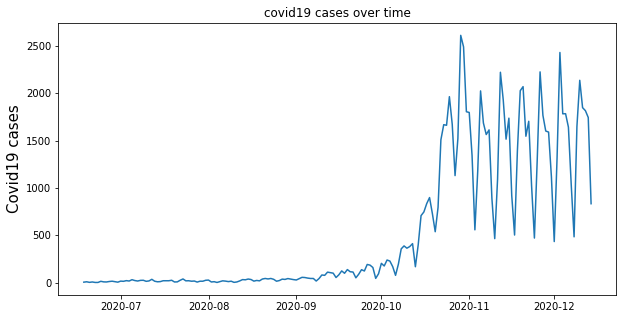

In [81]:
plt.figure(figsize=(10,5))
plt.plot(df['cases'])
plt.title("covid19 cases over time")
plt.ylabel('Covid19 cases', fontsize = 15)

In [82]:
From the plot above we can see there is some upward trend and strong seasonlaity in the series

SyntaxError: invalid syntax (<ipython-input-82-198e0d8bb5f2>, line 1)

### b. transform the data (if necessary), check stationarity (ADF, KPSS, comment) (10 point)

Let's initially do an ADF test and see if the series is stationary or not

In [ ]:
X0 = df['cases'].values
result = adfuller(X0)
print('ADF Statistics: %f' % result[0])
print('p-value: %f' % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print("Reject H0, so the time series is stationary")
else:
    print("Failed to reject H0, so the time series is not stationary")

Since the ADF_statisitics is greater than all 3 critical values(-1.228171 > -3.47, -1.228171 > -2.879, -1.228171 > -2.576), 
then we statistically prove that the time series is not stationary.

Now let's do the KPSS test...

In [83]:
res = kpss(df["cases"].values)
print('KPSS Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 1.648544
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In KPSS test we know that the Null hypothesis is claiming that the series is trend stationary, and the
alternative hypothesis claims that the series has a unit root so it is not trend stationary.

Since the pvalue is equal to 0.010000 which is less than 0.05, so we can conclude that the series has a unit root, so we can say that the series is not trend stationary.

Now let's do a first order differencing of the series

In [84]:
a = df["cases"].values[1:] 
b = df["cases"].values[:-1]
df["first_order_difference_cases"]= np.concatenate([[0], a - b])
df

<ipython-input-84-4a4e9f70f6ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["first_order_difference_cases"]= np.concatenate([[0], a - b])


,cases,first_order_difference_cases
dateRep,,
2020-12-14,833,0
2020-12-13,1744,911
2020-12-12,1816,72
2020-12-11,1848,32
2020-12-10,2137,289
...,...,...
2020-06-22,1,0
2020-06-21,6,5
2020-06-20,2,-4


Let's initially do an ADF test on Firat order differenced seroes and see if the series is stationary or not

In [85]:
X0 = df['first_order_difference_cases'].values
result = adfuller(X0)
print('ADF Statistics: %f' % result[0])
print('p-value: %f' % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print("Reject H0, so the time series is stationary")
else:
    print("Failed to reject H0, so the time series is not stationary")

ADF Statistics: -3.386446
p-value: 0.011430
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576
Reject H0, so the time series is stationary


In [86]:
So the first order differenced series is stationary...

SyntaxError: invalid syntax (<ipython-input-86-a01be3cc7557>, line 1)

Let's do KPSS Test on first order differenced series

In [87]:
res = kpss(df["first_order_difference_cases"].values)
print('KPSS Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.127000
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Since the pvalue is equal to 0.1 which is greater than 0.05, so we can conclude that the series has no a unit root, so we can say that the series is trend stationary.

so with the transformation series became stationary and trend stationary...

### c. identifying the dependence orders of the model (ACF, PACF diagnostic, comment) (5 point)

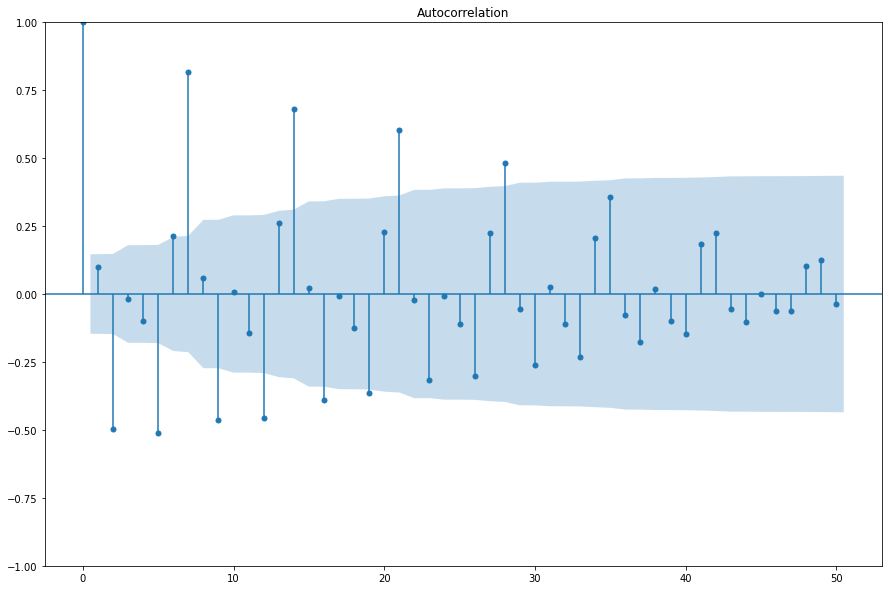

In [88]:
fig = plot_acf(df['first_order_difference_cases'].dropna(), lags = 50)
fig.set_size_inches((15, 10))
plt.show()

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


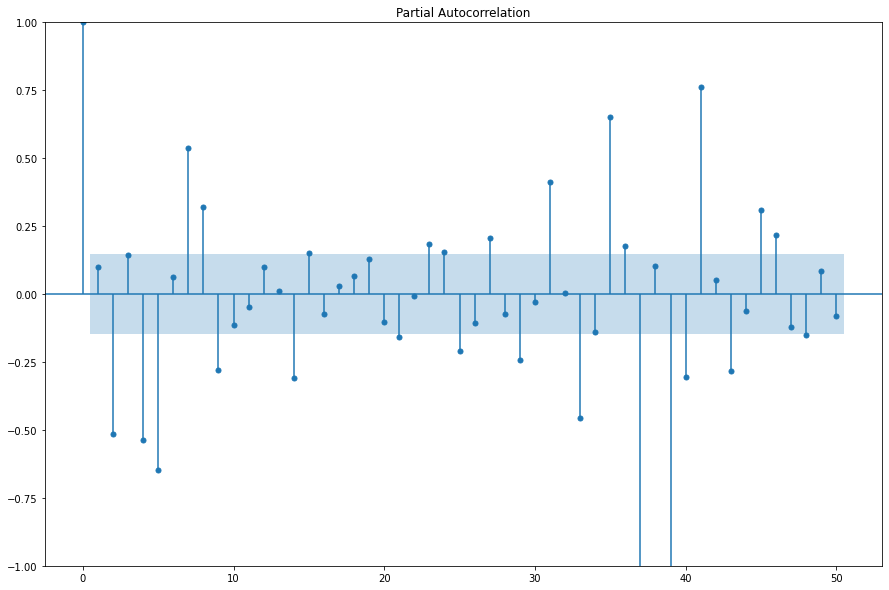

In [89]:
fig = plot_pacf(df['first_order_difference_cases'].dropna(), lags = 50)
fig.set_size_inches((15, 10))
plt.show()

So I will take Sarima model because I see some seasonality left in the Acf plot
So I will take p = 5, d = 1 q = 1, P = 1, D = 0, Q = 0  and m = 7(beacase its daily)
So SARIMA(5,1,1)(1,0,0)[7]

## d. Divide the data into train and test sets (95% vs 5%) estimate the model on train set (5 point)

In [90]:
df_train = df.iloc[:int(0.95*len(df))]
df_test = df.iloc[int(0.95*len(df)):]

In [91]:
sarima_model_1 = SARIMAX(df_train["cases"], order=(5, 1, 1), seasonal_order=(1, 0, 0, 7)).fit()
print(sarima_model_1.summary())

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              cases   No. Observations:                  171
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 7)   Log Likelihood               -1092.617
Date:                            Sat, 03 Dec 2022   AIC                           2201.234
Time:                                    10:10:52   BIC                           2226.320
Sample:                                         0   HQIC                          2211.414
                                            - 171                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6382      0.061     10.485      0.000       0.519       0.757
ar.L2          0.1730      0.078   

the coeficients of ar.l4, ar.l5 are not statistically sig because their p-values are greater than 0.5.
AIC is 2201, Skewedness is -0.85 which shows that the residuals' bell shape is little bit right skewed. Also for normality the value of kurtosis must be between -7 and 7 and in our case the value of kurtosis is 9.17 which shows that residuals are Near to  be normally distributed...

## e. residual diagnostics (including Ljung-Box test, comment) (5 point)


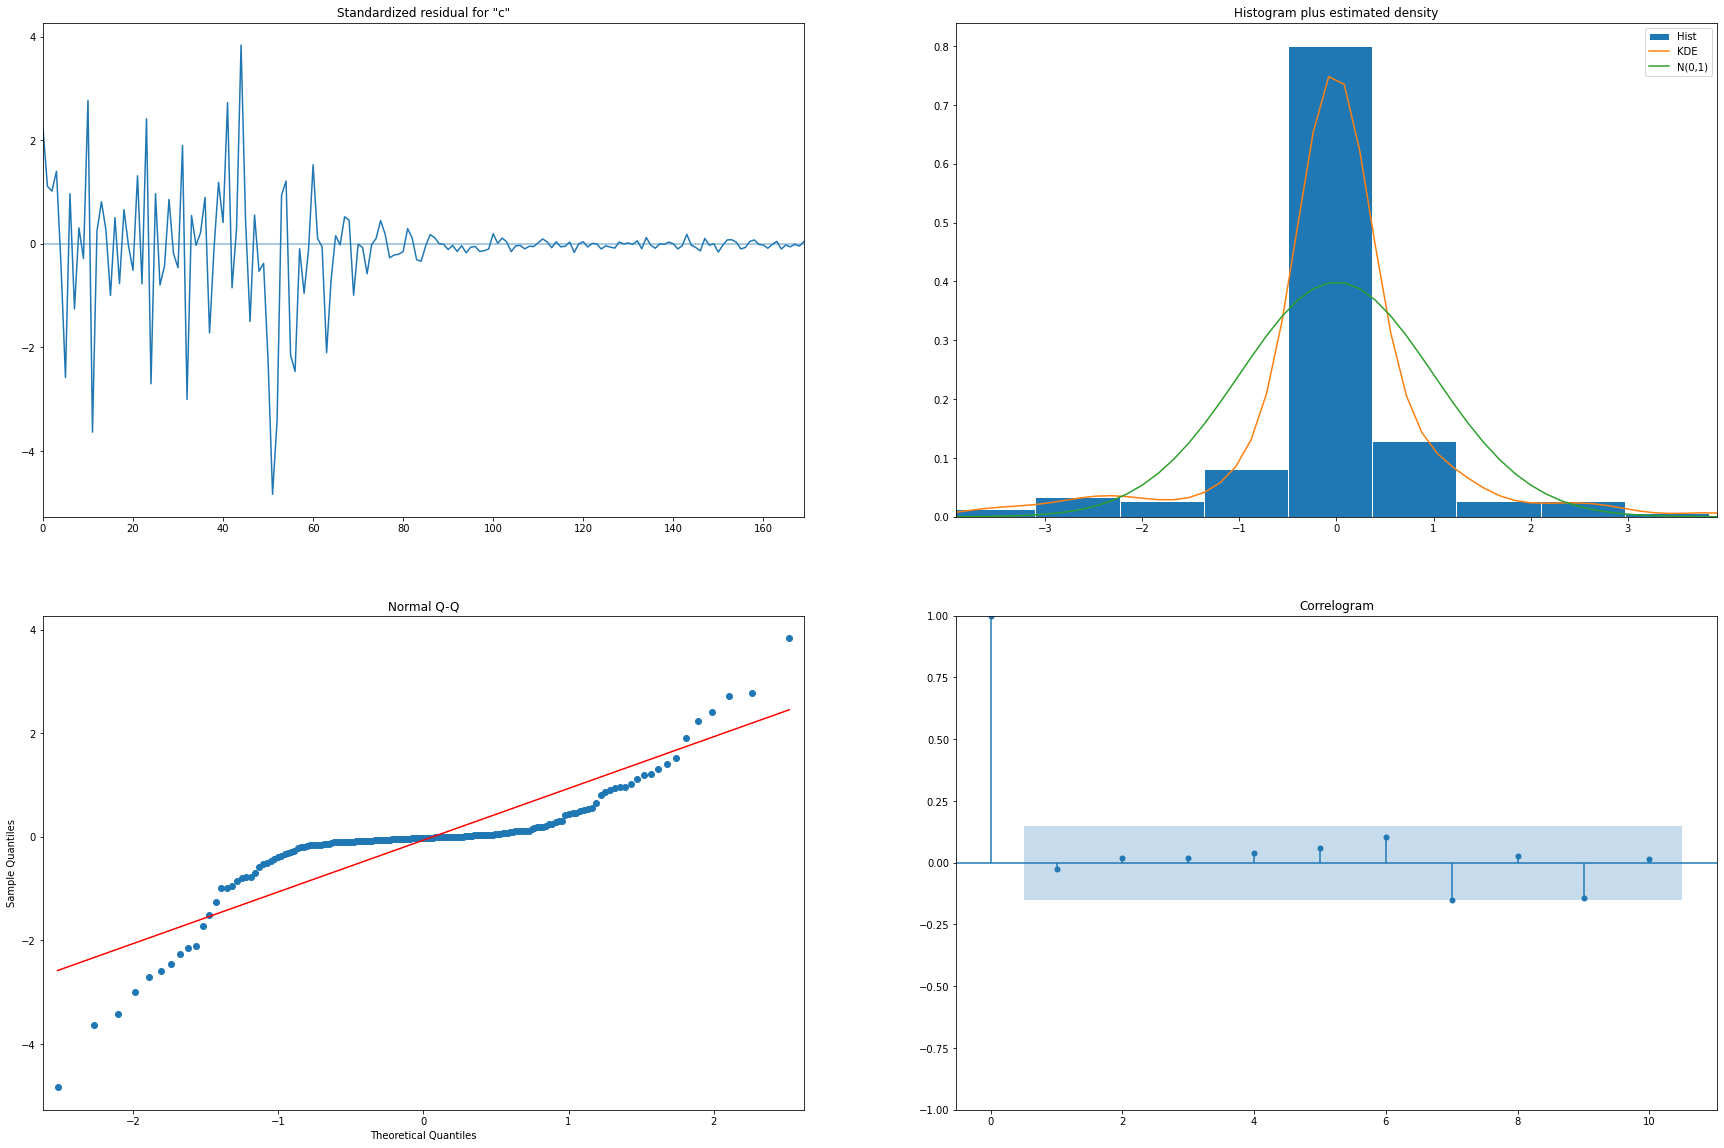

In [92]:
sarima_model_1.plot_diagnostics(figsize=(30,20))
plt.show()

Let's comment about the plots above. In the upper left plot we see that standardized residuals are near zero and are not very volatile.
In the histogram's plot we see that the KDE line is somehow close to the Normal(0, 1) bell shape curve.
In the QQ plot we see that points are near the Normal ab-line, but still they are not on the line.
And in the correlogram, we see that there is no significant lag, which means that residuals are normally distributed

Let's do ljung box test

In [93]:
residuals = sarima_model_1.resid
a=sm.stats.acorr_ljungbox(residuals, lags=12)
df_1=pd.DataFrame(a,columns=['lb_pvalue'])
df_1.index = np.arange(1, len(df_1)+1)
df_1

,lb_pvalue
1,0.005964
2,0.009762
3,0.013329
4,0.027817
5,0.015939
6,0.030198
7,0.046126
8,0.071736
9,0.075592
10,0.101807


So the residuals are not independent

### f. estimate model on train set with auto.arima, do forecast with both models for test set (rest 5% of the data), choose best model based on minimum Mean Squared Error (5 points)

In [94]:
sarima_model_2 = pm.auto_arima(df_train["cases"],
                      start_p =0,
                      start_q = 0,
                      test='adf',       
                      m = 7,              
                      d = 1,
                      D = 0,
                      seasonal= True,   
                      start_P=0,  
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings= True )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2337.159, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2464.987, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2210.081, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2336.784, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2463.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2465.169, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2208.544, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2338.733, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=2210.757, Time=0.36 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2300.980, Time=0.13 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2216.960, Time=0.15 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=2205.9

In [95]:
sarima_model_2 = SARIMAX(df_train["cases"], order=(2,1,0), seasonal_order=(1,0,1,7))
sarima_model_2 = sarima_model_2.fit()
print(sarima_model_2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               cases   No. Observations:                  171
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1096.980
Date:                             Sat, 03 Dec 2022   AIC                           2203.959
Time:                                     10:11:03   BIC                           2219.638
Sample:                                          0   HQIC                          2210.322
                                             - 171                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2879      0.043     -6.687      0.000      -0.372      -0.204
ar.L2         -0.1676      

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [96]:
print(f"AIC Model 1: {sarima_model_1.aic}")
print(f"AIC Model 2: {sarima_model_2.aic}\n")
print(f"BIC Model 1: {sarima_model_1.bic}")
print(f"BIC Model 2: {sarima_model_2.bic}\n")

AIC Model 1: 2201.2341075467616
AIC Model 2: 2203.959271471068

BIC Model 1: 2226.3204950431636
BIC Model 2: 2219.6382636563194



AICs are really close

firstly let's do the testing

In [100]:

#Secondly let's get the forecast values of the best SARIMA model on test data

sarima_model_1_forecasts_on_test = sarima_model_2.forecast(len(df_test), alpha=0.05)

#Thirdly let's get the forecast values of the AR(1) model on test data
sarima_model_2_forecats_on_test = sarima_model_2.forecast(len(df_test), alpha=0.05)

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [98]:
print('the MSE of the SARIMA(5,1,1)(1,0,0)[7] model is', mean_squared_error(df_test["cases"], sarima_model_1_forecasts_on_test))
print('the MSE of the SARIMA(2,1,0)(1,0,1)[7]  model is', mean_squared_error(df_test["cases"], sarima_model_2_forecats_on_test))

the MSE of the SARIMA(5,1,1)(1,0,0)[7] model is 10.474033743870544
the MSE of the SARIMA(2,1,0)(1,0,1)[7]  model is 10.474033743870544


In [ ]:
MSE values are really close so they are equivalent 

## g. Estimate best model for original data (100%), forecast with best model for the periods mentioned in the problem, plot the data and forecast (10 point)


In [ ]:
## I will do the forecast with sarima_model_2

In [103]:
sarima_model_2_forecats_on_test

171    11.342696
172     6.770977
173     8.409262
174    -1.084051
175     3.508763
176     9.389089
177     4.470318
Name: predicted_mean, dtype: float64

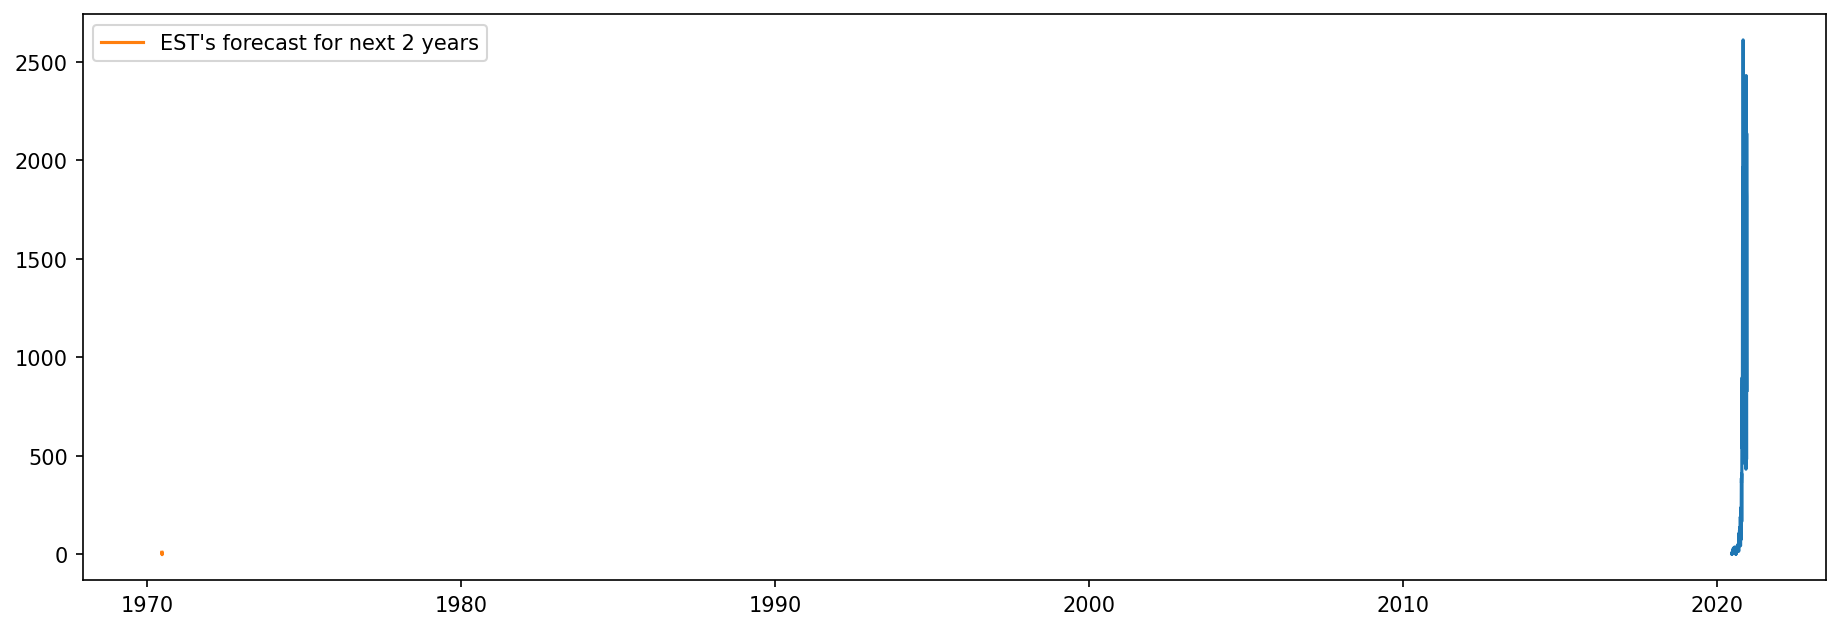

In [104]:

#sarima_model_2_forecats_on_test = sarima_model_2.forecast(7, alpha=0.05)
plt.figure(figsize=(15,5),dpi=150)
plt.plot(df["cases"])
plt.plot(sarima_model_2_forecats_on_test , label="EST's forecast for next 2 years")
plt.legend()

In [105]:
df2 = pd.read_excel("dataset.xlsx", index_col = 0, parse_dates=[0] )
df2 = df2.loc[df2['coin_name'] == df2["coin_name"].sample(random_state=90061).values.tolist()[0]]

### For the modeling you can use one of these columns low, high, open, close

## a. Plot the data and describe the main features of the series, i.e. seasonality (additive or multiplicative), trend (additive or multiplicative). (5 points)

Text(0, 0.5, 'Values of Close')

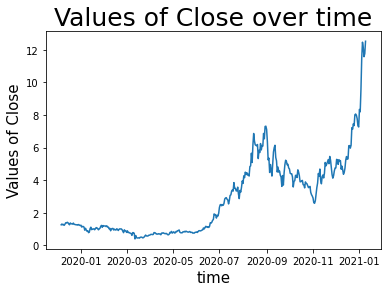

In [108]:
df2 = df2[df2["close"]!=0]
plt.plot(df2["close"])
plt.title("Values of Close over time", fontsize = 25)
plt.xlabel('time', fontsize = 15)
plt.ylabel('Values of Close', fontsize = 15)

In [ ]:
There is an upward trend, but I am not sure about the seasonality...

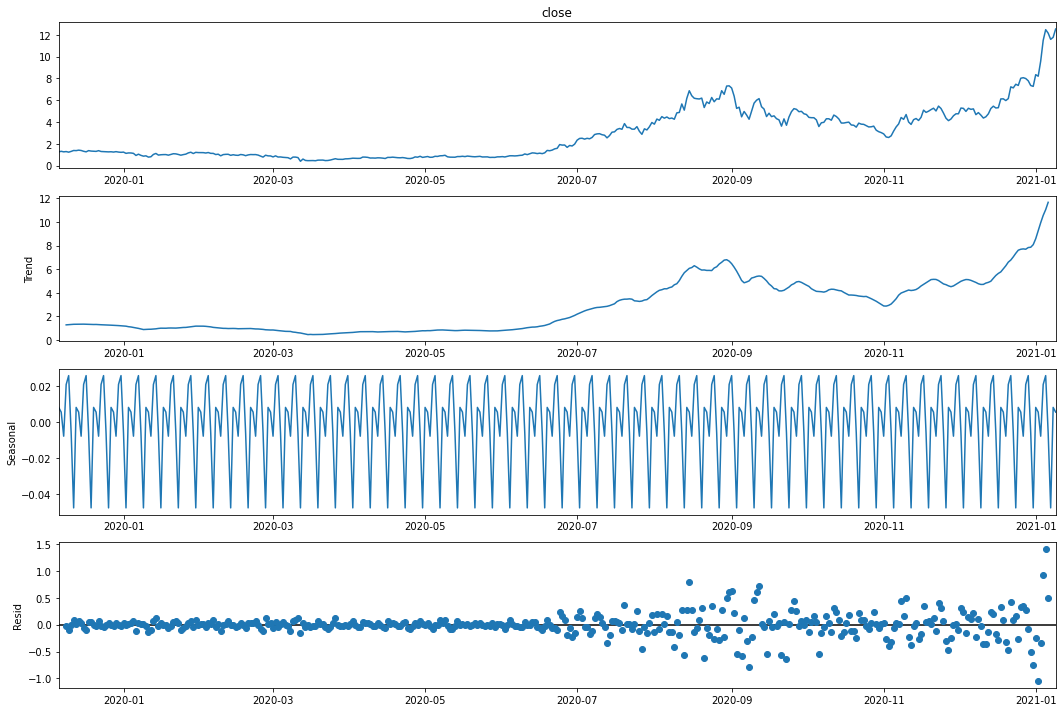

In [110]:
model_add = seasonal_decompose(df2['close'], model='additive', period = 7)#its daily data so freq is 7
fig = model_add.plot()
fig.set_size_inches((15, 10))
fig.tight_layout()
plt.show()

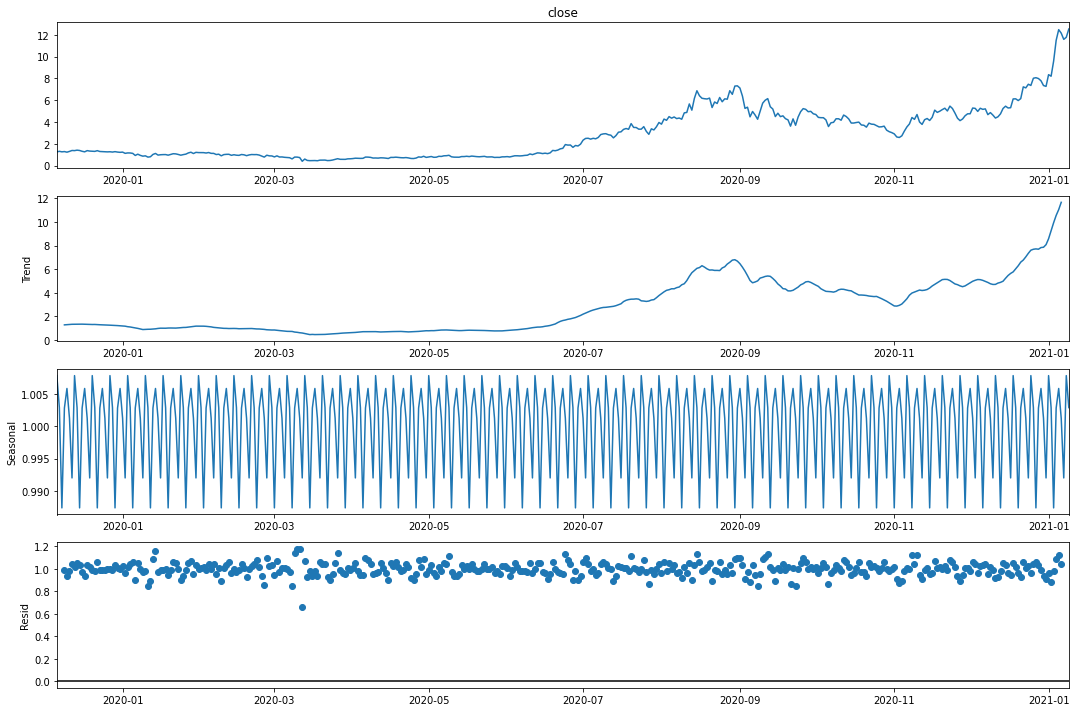

In [122]:
model_mul = seasonal_decompose(df2['close'], model='multiplicative', period = 7)
fig = model_mul.plot()
fig.set_size_inches((15, 10))
fig.tight_layout()
plt.show()

As we see in the decomposed plots above, in the additive version the residuals are close to 0, while in the multiplicative one they are concentrated near 1. We get to the conclusion that when decomposing a series, additive decomposition produces random errors but multiplicative decomposition does not, meaning that the trend and the seasonality are additive.

In [123]:
## b. Divide series into two parts (90% vs 10%). Use Exponential Smoothing to choose ETS model for the train set, specify seasonality and trend as none. (10 points) 


In [124]:
df_train = df2.iloc[:int(0.9*len(df))]
df_test = df2.iloc[int(0.9*len(df)):]

In [125]:
#as given in the assignment I put trend = None, seasonal = None, and because we have monthly data I put seasonal_periods = 7
no_seasonality_no_trend = ExponentialSmoothing(df_train["close"], trend=None, seasonal=None, seasonal_periods = 7).fit()
fitted_values=no_seasonality_no_trend.fittedvalues
print(no_seasonality_no_trend.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                  162
Model:             ExponentialSmoothing   SSE                              0.750
Optimized:                         True   AIC                           -866.787
Trend:                             None   BIC                           -860.612
Seasonal:                          None   AICC                          -866.533
Seasonal Periods:                  None   Date:                 Sat, 03 Dec 2022
Box-Cox:                          False   Time:                         10:32:17
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6649066                alpha                 True
initial_level              1.26699

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


c.

In [127]:
additive_trend_and_no_seasonality = ExponentialSmoothing(df_train["close"],trend='add',seasonal=None,seasonal_periods = 7).fit()
additive_trend_and_additive_seasonality = ExponentialSmoothing(df_train["close"],trend='add',seasonal='add',seasonal_periods = 7).fit()
no_trend_and_additive_seasonality = ExponentialSmoothing(df_train["close"],trend=None,seasonal='add',seasonal_periods = 7).fit()
multiplicative_trend_and_multiplicative_seasonality = ExponentialSmoothing(df_train["close"],trend='mul',seasonal='mul',seasonal_periods = 7).fit()
no_trend_and_multiplicative_seasonality = ExponentialSmoothing(df_train["close"],trend=None ,seasonal='mul',seasonal_periods = 7).fit()
multiplicative_trend_and_no_seasonality = ExponentialSmoothing(df_train["close"],trend='mul',seasonal=None ,seasonal_periods = 7).fit()
additive_trend_and_multiplicative_seasonality = ExponentialSmoothing(df_train["close"],trend="add" ,seasonal='mul',seasonal_periods = 7).fit()
multiplicative_trend_and_additive_seasonality = ExponentialSmoothing(df_train["close"],trend="mul" ,seasonal='add',seasonal_periods = 7).fit()

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

In [128]:
print(f"AIC of model 1: {additive_trend_and_no_seasonality.aic}")
print(f"AIC of model 2: {additive_trend_and_additive_seasonality.aic}")
print(f"AIC of model 3: {no_trend_and_additive_seasonality.aic}")
print(f"AIC of model 4: {multiplicative_trend_and_multiplicative_seasonality.aic}")
print(f"AIC of model 5: {no_trend_and_multiplicative_seasonality.aic}")
print(f"AIC of model 6: {multiplicative_trend_and_no_seasonality.aic}")
print(f"AIC of model 7: {additive_trend_and_multiplicative_seasonality.aic}")
print(f"AIC of model 8: {multiplicative_trend_and_additive_seasonality.aic}\n")

print(f"BIC of model 1: {additive_trend_and_no_seasonality.bic}")
print(f"BIC of model 2: {additive_trend_and_additive_seasonality.bic}")
print(f"BIC of model 3: {no_trend_and_additive_seasonality.bic}")
print(f"BIC of model 4: {multiplicative_trend_and_multiplicative_seasonality.bic}")
print(f"BIC of model 5: {no_trend_and_multiplicative_seasonality.bic}")
print(f"BIC of model 6: {multiplicative_trend_and_no_seasonality.bic}")
print(f"BIC of model 7: {additive_trend_and_multiplicative_seasonality.bic}")
print(f"BIC of model 8: {multiplicative_trend_and_additive_seasonality.bic}\n")

AIC of model 1: -863.413246883643
AIC of model 2: -856.5726954979926
AIC of model 3: -859.9425188596628
AIC of model 4: -854.326040850235
AIC of model 5: -856.9285688966115
AIC of model 6: -864.1888618859895
AIC of model 7: -853.5381630570985
AIC of model 8: -858.8594668555572

BIC of model 1: -851.0628615427134
BIC of model 2: -822.6091358104364
BIC of model 3: -832.1541518425713
BIC of model 4: -820.3624811626788
BIC of model 5: -829.1402018795201
BIC of model 6: -851.83847654506
BIC of model 7: -819.5746033695423
BIC of model 8: -824.895907168001



the least aic is in the case when no_trend_and_no_seasonality -866

d. Check the residuals of your preferred ETS model (ACF, QQ plot, Ljung-Box test, comment on all
results). (10 points) 

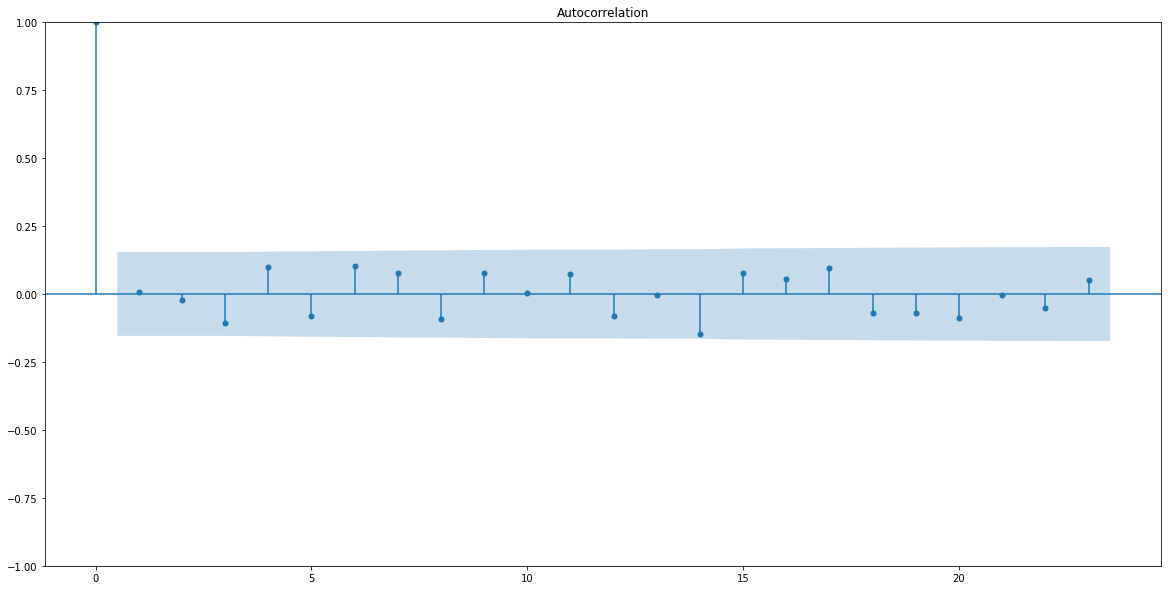

In [129]:
residuals = no_trend_and_multiplicative_seasonality.resid
fig = plot_acf(residuals)
fig.set_size_inches((20, 10))
plt.show()

The last significant lAG IS the 3rd lag, so we have no info left in the series, it is near to be white noise...

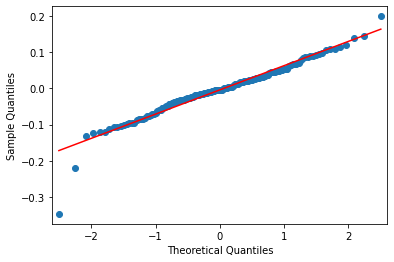

In [130]:
##Now let's look at the QQ-plot of residuals
sm.qqplot(residuals,dist = scipy.stats.distributions.norm,line = 'r')
plt.show()

It is very like normal

In [131]:
a=sm.stats.acorr_ljungbox(residuals, lags=15)
df_1=pd.DataFrame(a,columns=['lb_pvalue'])
df_1.index = np.arange(1, len(df_1)+1)
df_1

,lb_pvalue
1,0.907684
2,0.947500
3,0.576772
4,0.457800
5,0.449699
6,0.364945
7,0.373785
8,0.340399
9,0.347146
10,0.436731


The residuals are iid

In [ ]:
e. Use auto.arima function and choose the best SARIMA model (comment). (10 points) 


In [133]:
sarima_model_3 = pm.auto_arima(df_train["close"],
                      start_p =0,
                      start_q = 0,
                   
                      test='adf',       
                      m = 7,              
                      d = 0,
                      D = 0,
                      seasonal= True,   
                      start_P=0,  
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings= True )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-98.958, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17.670, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-389.944, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-205.126, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=442.572, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=-389.296, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=-389.749, Time=0.36 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=-390.814, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=-367.851, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=-399.910, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=-398.789, Time=0.09 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=inf, Time=

In [135]:
sarima_model_3 = SARIMAX(df_train["close"], order=(1,0,1), seasonal_order=(0,0,1,7))
sarima_model_3 = sarima_model_3.fit()
print(sarima_model_3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                  162
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood                 203.536
Date:                           Sat, 03 Dec 2022   AIC                           -399.073
Time:                                   10:35:43   BIC                           -386.722
Sample:                               12-06-2019   HQIC                          -394.058
                                    - 05-15-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.004    281.323      0.000       0.992       1.006
ma.L1         -0.3323      0.065     -5.116

C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


f. Forecast for the test set with best SARIMA and Best ETS models. Compare forecasting performance
of two models over the test set, e.g. calculate MSEs or MAPE. Which model do you prefer
(comment)? (10 points) 

In [136]:
#Firstly let's get the forecast values of exponential smoothing model on test data
no_seasonality_no_trend = ExponentialSmoothing(df_train["close"], trend=None, seasonal=None, seasonal_periods = 7).fit()
exp_smoothing_forecasts_on_test = no_seasonality_no_trend.forecast(len(df_test))

#Secondly let's get the forecast values of the best SARIMA model on test data

sarima_forecasts_on_test = sarima_model_3.forecast(len(df_test), alpha=0.05)


C:\Users\37498\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [138]:

print('the MSE of the Exponential Smoothing model is', mean_squared_error(df_test["close"], exp_smoothing_forecasts_on_test))
print('the MSE of the SARIMA model is', mean_squared_error(df_test["close"], sarima_forecasts_on_test))

the MSE of the Exponential Smoothing model is 16.34821987994291
the MSE of the SARIMA model is 17.385242818452593


So the ETs's MSE is smaller, its better

g. Estimate two models from part g on original data (train + test). Generate and plot forecasts for the
next 10 days with both models. (10 points)

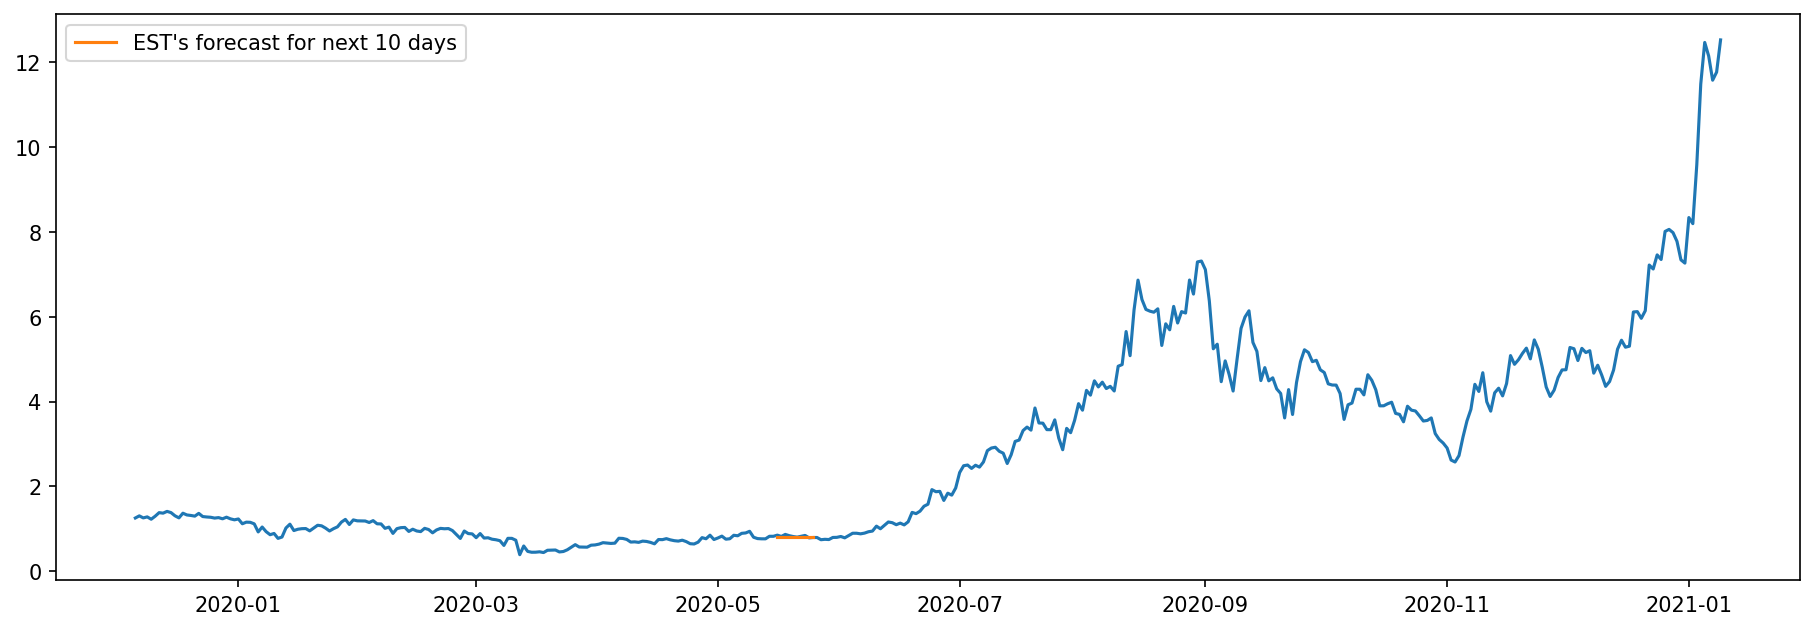

In [141]:
exp_smoothing_forecasts_for_the_next_two_years = no_seasonality_no_trend.forecast(10)
#In this plot there is shown the EST's forecast for next 2 years
plt.figure(figsize=(15,5),dpi=150)
plt.plot(df2["close"])
plt.plot(exp_smoothing_forecasts_for_the_next_two_years , label="EST's forecast for next 10 days")
plt.legend()

In [ ]:
exp_smoothing_forecasts_for_the_next_two_years = no_seasonality_no_trend.forecast(10)
#In this plot there is shown the EST's forecast for next 2 years
plt.figure(figsize=(15,5),dpi=150)
plt.plot(df2["close"])
plt.plot(exp_smoothing_forecasts_for_the_next_two_years , label="EST's forecast for next 10 days")
plt.legend()